In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error


In [ ]:
df = pd.read_csv('/content/sample_data/VCB.csv')
df

,Date,Close,Open,High,Low,Vol.,Change %
0,12/1/2017,36620,36847,37075,36392,2.66M,-0.41%
1,12/4/2017,37454,36772,37454,36620,2.48M,2.28%
2,12/5/2017,36468,37151,37909,36468,2.52M,-2.63%
3,12/6/2017,36392,36392,36620,35710,2.68M,-0.21%
4,12/7/2017,36089,36392,36392,35407,3.49M,-0.83%
...,...,...,...,...,...,...,...
1369,6/1/2023,93900,94600,94600,93200,646.30K,-0.11%
1370,6/2/2023,94900,93900,95000,93300,737.80K,1.06%
1371,6/5/2023,98000,95200,98700,95200,1.30M,3.27%
1372,6/6/2023,99000,98000,99000,96500,759.50K,1.02%


In [ ]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập validation
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Lấy các giá trị đóng cửa của tập huấn luyện
train_close_prices = train_data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu về phạm vi từ 0 đến 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_close_prices)

# Xác định input và output của tập huấn luyện
train_input = scaled_train_prices[:-1]
train_output = scaled_train_prices[1:]

In [ ]:
# Tạo một mô hình SVR
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1)

# Huấn luyện mô hình
svr_model.fit(train_input, train_output)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000.0, gamma=0.1)

In [ ]:
# Dự đoán trên tập validation
val_close_prices = val_data['Close'].values.reshape(-1, 1)
scaled_val_prices = scaler.transform(val_close_prices)
val_input = scaled_val_prices[:-1]
val_output = scaled_val_prices[1:]
val_predictions = svr_model.predict(val_input)

In [ ]:

# Tính toán các độ đo đánh giá trên tập validation
val_mape = mean_absolute_percentage_error(val_output, val_predictions)
val_mse = mean_squared_error(val_output, val_predictions)
val_mae = mean_absolute_error(val_output, val_predictions)
val_rmse = np.sqrt(val_mse)

In [ ]:
# Tính toán các độ đo đánh giá trên tập test
test_close_prices = test_data['Close'].values.reshape(-1, 1)
scaled_test_prices = scaler.transform(test_close_prices)
test_input = scaled_test_prices[:-1]
test_output = scaled_test_prices[1:]
test_predictions = svr_model.predict(test_input)
test_mape = mean_absolute_percentage_error(test_output, test_predictions)
test_mse = mean_squared_error(test_output, test_predictions)
test_mae = mean_absolute_error(test_output, test_predictions)
test_rmse = np.sqrt(test_mse)

In [ ]:
# In các độ đo đánh giá
print('Validation MAPE:', val_mape)
print('Validation MSE:', val_mse)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Test MAPE:', test_mape)
print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test RMSE:', test_rmse)


Validation MAPE: 0.058280239217005154
Validation MSE: 0.004097160349842399
Validation MAE: 0.057634483655915086
Validation RMSE: 0.06400906459121551
Test MAPE: 0.03749270748981919
Test MSE: 0.0014092786607367656
Test MAE: 0.030575599478705414
Test RMSE: 0.03754036042363959


In [ ]:
# Dự đoán 30 ngày tiếp theo
last_input = scaled_val_prices[-1:]
predicted_prices = []
for _ in range(30):
    predicted_price = svr_model.predict(last_input.reshape(1, -1))
    predicted_prices.append(predicted_price)
    last_input = predicted_price

In [ ]:
# Scale dự đoán trở lại với đơn vị gốc
predicted_prices = scaler.inverse_transform(predicted_prices)



In [ ]:
# SCale lai gia tri du doan
val_predictions_scaled = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()


In [ ]:
# Tạo mảng ngày tương ứng với các dự đoán
last_date = pd.to_datetime(df['Date'].iloc[-1])
predicted_dates = pd.date_range(start=last_date, periods=30, inclusive=None)



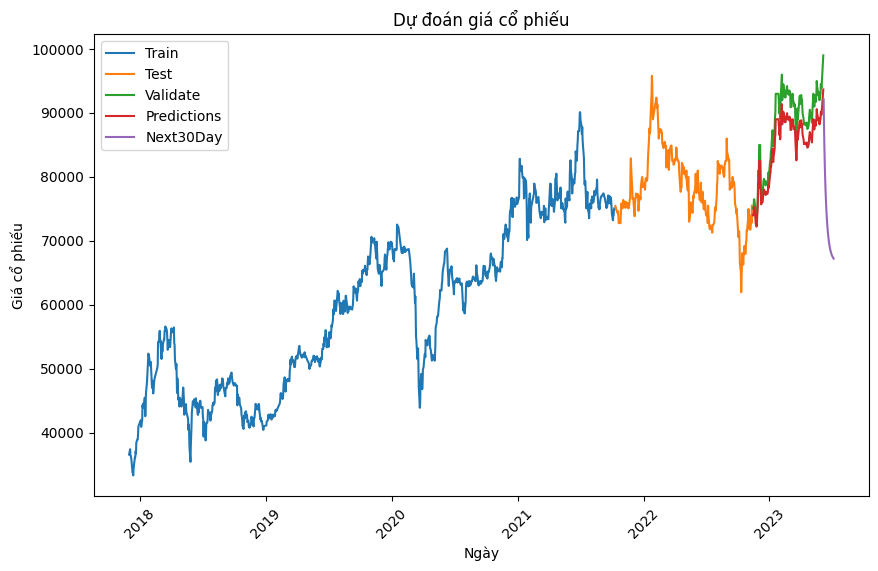

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(train_data['Date']), train_data['Close'], label='Train')
plt.plot(pd.to_datetime(test_data['Date']), test_data['Close'], label='Test')
plt.plot(pd.to_datetime(val_data['Date'][:-1]), val_close_prices[:-1], label='Validate')
plt.plot(pd.to_datetime(val_data['Date'][:-1]), val_predictions_scaled, label='Predictions')
plt.plot(predicted_dates, predicted_prices, label='Next30Day')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Dự đoán giá cổ phiếu')
plt.legend()
plt.xticks(rotation=45)
plt.show()